In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import cv2, random
from pathlib import Path
import dataclasses

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


from warnings import filterwarnings
filterwarnings("ignore")

import os
import sys
sys.path.append(os.path.join(str(os.path.abspath('')), "..", "..", "..", ".."))
from src.detector.get_dicts import get_COVID19_data_dicts
from src.detector.custom_trainer import MyTrainer
from src.detector.flags import Flags
from src.detector.save_yaml import save_yaml


setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
flags_dict = {
    "debug": False,
    "fold": 3,
    "outdir": "results/", 
    "root_imgdir": PATH_TO_IMAGES, # !!! DEFINE "PATH_TO_IMAGES" on your local machine,
    "path_to_meta_df": "../../cross_validation_scheme/modified_detectron_data/meta_df.csv",
    "path_to_train_df": "../../cross_validation_scheme/modified_detectron_data/detectron_prepared_df.csv",
    "use_cache": False,
    "img_size": "1024x1024",
    "cv_scheme": "skf",
    "use_negative": False,
    "binary_task": True,
    
    "iter": 4000,
    "roi_batch_size_per_image": 256,
    "eval_period": 1000,
#     "lr_scheduler_name": "WarmupMultiStepLR",
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.0025,
    "num_workers": 4,
    "ims_per_batch": 8,
    
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "HueSaturationValue": {"hue_shift_limit": 10, "sat_shift_limit": 10, "val_shift_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CLAHE": {"clip_limit": (1,4), "p": 0.5},
        "GaussianBlur": {"p": 0.5}
    },
}

In [3]:
flags = Flags().update(flags_dict)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

In [4]:
thing_classes = [
    "opacity"
]

In [5]:
DatasetCatalog.register(
    "COVID19_data_train",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='train',
                                    fold=flags.fold,
                                  ),
)
MetadataCatalog.get("COVID19_data_train").set(thing_classes=thing_classes)


DatasetCatalog.register(
    "COVID19_data_valid",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='val',
                                    fold=flags.fold,
                                  ),
    )
MetadataCatalog.get("COVID19_data_valid").set(thing_classes=thing_classes)

dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")

dataset_dicts_valid = DatasetCatalog.get("COVID19_data_valid")
metadata_dicts_valid = MetadataCatalog.get("COVID19_data_valid")

  2%|▏         | 76/4818 [00:00<00:06, 758.56it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


  7%|▋         | 79/1212 [00:00<00:01, 783.03it/s]

Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/001bd15d1891.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1212/1212 [00:01<00:00, 804.13it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl


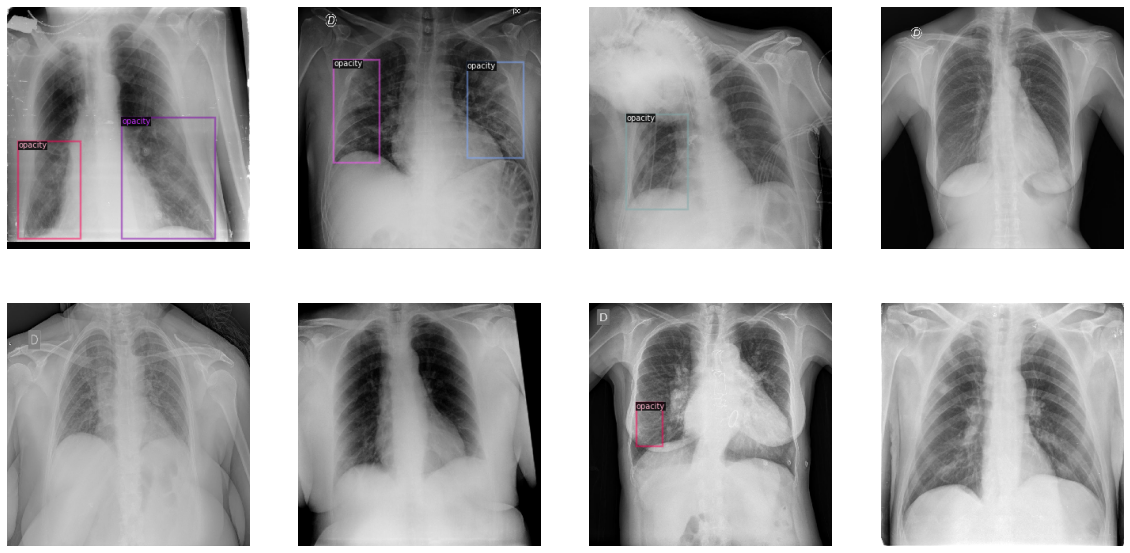

In [6]:
fig, ax = plt.subplots(2, 4, figsize =(20,10))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1],ax[0][2],ax[1][2],ax[0][3],ax[1][3]]
i=-1
for d in random.sample(dataset_dicts_train, 8):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts_train, 
                   scale=0.3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [7]:
from detectron2.config.config import CfgNode as CN

cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)  # pass aug_kwargs to cfg

original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = flags.outdir
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("COVID19_data_train",)
cfg.DATASETS.TEST = ("COVID19_data_valid",)
cfg.TEST.EVAL_PERIOD = flags.eval_period

cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

Loading config /home/greylord/siim_covid/covid_env/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


cfg.OUTPUT_DIR ./output -> results/


In [8]:
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/01 02:49:21 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

  2%|▏         | 76/4818 [00:00<00:06, 759.96it/s]

[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None),
  HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-10, 10), sat_shift_limit=(-10, 10), val_shift_limit=(-10, 10)),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4), tile_grid_size=(8, 8)),
  GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 7), sigma_limit=(0, 0)),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating dat

100%|██████████| 4818/4818 [00:06<00:00, 795.54it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 02:49:28 d2.data.build]: Removed 1389 images with no usable annotations. 3429 images left.
[08/01 02:49:28 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  opacity   | 6268         |
|            |              |
[08/01 02:49:28 d2.data.build]: Using training sampler TrainingSampler
[08/01 02:49:28 d2.data.common]: Serializing 3429 elements to byte tensors and concatenating them all ...
[08/01 02:49:28 d2.data.common]: Serialized dataset takes 1.20 MiB


  0%|          | 0/1212 [00:00<?, ?it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/001bd15d1891.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1212/1212 [00:01<00:00, 809.11it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 02:49:29 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  opacity   | 1584         |
|            |              |
[08/01 02:49:29 d2.data.common]: Serializing 1212 elements to byte tensors and concatenating them all ...
[08/01 02:49:29 d2.data.common]: Serialized dataset takes 0.37 MiB
[08/01 02:49:29 d2.engine.train_loop]: Starting training from iteration 0
[08/01 02:49:51 d2.utils.events]:  eta: 1:08:43  iter: 19  total_loss: 2.262  loss_cls: 1.376  loss_box_reg: 0.8714  time: 1.0545  data_time: 0.0329  lr: 4.2996e-05  max_mem: 18669M
[08/01 02:50:12 d2.utils.events]:  eta: 1:08:34  iter: 39  total_loss: 1.135  loss_cls: 0.5709  loss_box_reg: 0.5609  time: 1.0523  data_time: 0.0143  lr: 8.5624e-05  max_mem: 18669M
[08/01 02:50:33 d2.utils.events]:  eta: 1:08:19  iter: 59  total_l

[08/01 03:03:51 d2.utils.events]:  eta: 0:55:33  iter: 819  total_loss: 0.7569  loss_cls: 0.3203  loss_box_reg: 0.4391  time: 1.0500  data_time: 0.0159  lr: 0.0017481  max_mem: 18669M
[08/01 03:04:12 d2.utils.events]:  eta: 0:55:13  iter: 839  total_loss: 0.76  loss_cls: 0.3395  loss_box_reg: 0.4441  time: 1.0501  data_time: 0.0152  lr: 0.0017907  max_mem: 18669M
[08/01 03:04:33 d2.utils.events]:  eta: 0:54:52  iter: 859  total_loss: 0.8335  loss_cls: 0.3743  loss_box_reg: 0.4569  time: 1.0501  data_time: 0.0165  lr: 0.0018334  max_mem: 18669M
[08/01 03:04:54 d2.utils.events]:  eta: 0:54:31  iter: 879  total_loss: 0.8014  loss_cls: 0.3648  loss_box_reg: 0.4489  time: 1.0501  data_time: 0.0154  lr: 0.001876  max_mem: 18669M
[08/01 03:05:15 d2.utils.events]:  eta: 0:54:10  iter: 899  total_loss: 0.7348  loss_cls: 0.3177  loss_box_reg: 0.416  time: 1.0501  data_time: 0.0151  lr: 0.0019186  max_mem: 18669M
[08/01 03:05:36 d2.utils.events]:  eta: 0:53:49  iter: 919  total_loss: 0.8123  loss

  7%|▋         | 83/1212 [00:00<00:01, 821.35it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/001bd15d1891.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1212/1212 [00:01<00:00, 836.61it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 03:07:02 d2.data.common]: Serializing 1212 elements to byte tensors and concatenating them all ...
[08/01 03:07:02 d2.data.common]: Serialized dataset takes 0.37 MiB
[08/01 03:07:02 d2.evaluation.coco_evaluation]: 'COVID19_data_valid' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[08/01 03:07:02 d2.data.datasets.coco]: Converting annotations of dataset 'COVID19_data_valid' to COCO format ...)



  7%|▋         | 82/1212 [00:00<00:01, 818.87it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/001bd15d1891.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1212/1212 [00:01<00:00, 836.44it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 03:07:03 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[08/01 03:07:04 d2.data.datasets.coco]: Conversion finished, #images: 1212, #annotations: 1584
[08/01 03:07:04 d2.data.datasets.coco]: Caching COCO format annotations at 'results/inference/COVID19_data_valid_coco_format.json' ...
[08/01 03:07:04 d2.evaluation.evaluator]: Start inference on 1212 images
[08/01 03:07:05 d2.evaluation.evaluator]: Inference done 11/1212. 0.0534 s / img. ETA=0:01:05
[08/01 03:07:10 d2.evaluation.evaluator]: Inference done 102/1212. 0.0532 s / img. ETA=0:01:01
[08/01 03:07:15 d2.evaluation.evaluator]: Inference done 193/1212. 0.0531 s / img. ETA=0:00:56
[08/01 03:07:20 d2.evaluation.evaluator]: Inference done 284/1212. 0.0531 s / img. ETA=0:00:51
[08/01 03:07:25 d2.evaluation.evaluator]: Inference done 374/1212. 0.0533 s / img. ETA=0:00:46
[08/01 03:07:30 d2.evaluation.evaluator]: Inference done 465/1212. 0.0533 s / img. ETA=0:00:41
[08/01 03:07:35 d2.evaluation.evaluator]: Inference done 556/1212. 0.0533 s / img. ETA=0:00:36
[08/01 03:07:40 d2.evaluation.eva

[08/01 03:15:35 d2.utils.events]:  eta: 0:46:35  iter: 1339  total_loss: 0.7634  loss_cls: 0.3215  loss_box_reg: 0.4461  validation_loss: 0.8062  time: 1.0571  data_time: 0.0168  lr: 0.0018702  max_mem: 18669M
[08/01 03:15:58 d2.utils.events]:  eta: 0:46:15  iter: 1359  total_loss: 0.7649  loss_cls: 0.3178  loss_box_reg: 0.4447  validation_loss: 0.8062  time: 1.0584  data_time: 0.0168  lr: 0.0018531  max_mem: 18669M
[08/01 03:16:20 d2.utils.events]:  eta: 0:45:54  iter: 1379  total_loss: 0.7153  loss_cls: 0.2921  loss_box_reg: 0.4169  validation_loss: 0.8062  time: 1.0588  data_time: 0.0154  lr: 0.0018358  max_mem: 18669M
[08/01 03:16:42 d2.utils.events]:  eta: 0:45:34  iter: 1399  total_loss: 0.7212  loss_cls: 0.3117  loss_box_reg: 0.4213  validation_loss: 0.8062  time: 1.0593  data_time: 0.0164  lr: 0.0018184  max_mem: 18669M
[08/01 03:17:04 d2.utils.events]:  eta: 0:45:13  iter: 1419  total_loss: 0.6798  loss_cls: 0.2813  loss_box_reg: 0.4107  validation_loss: 0.8062  time: 1.0601  

  7%|▋         | 79/1212 [00:00<00:01, 789.27it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/001bd15d1891.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1212/1212 [00:01<00:00, 811.38it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 03:27:24 d2.data.common]: Serializing 1212 elements to byte tensors and concatenating them all ...
[08/01 03:27:24 d2.data.common]: Serialized dataset takes 0.37 MiB
[08/01 03:27:24 d2.evaluation.evaluator]: Start inference on 1212 images
[08/01 03:27:24 d2.evaluation.evaluator]: Inference done 11/1212. 0.0532 s / img. ETA=0:01:05
[08/01 03:27:29 d2.evaluation.evaluator]: Inference done 102/1212. 0.0535 s / img. ETA=0:01:01
[08/01 03:27:34 d2.evaluation.evaluator]: Inference done 193/1212. 0.0535 s / img. ETA=0:00:56
[08/01 03:27:40 d2.evaluation.evaluator]: Inference done 284/1212. 0.0535 s / img. ETA=0:00:51
[08/01 03:27:45 d2.evaluation.evaluator]: Inference done 375/1212. 0.0535 s / img. ETA=0:00:46
[08/01 03:27:50 d2.evaluation.evaluator]: Inference done 465/1212. 0.0535 s / img. ETA=0:00:41
[08/01 03:27:55 d2.evaluation.evaluator]: Inference done 556/1212

[08/01 03:35:47 d2.utils.events]:  eta: 0:29:10  iter: 2339  total_loss: 0.679  loss_cls: 0.2743  loss_box_reg: 0.4051  validation_loss: 0.7776  time: 1.0604  data_time: 0.0166  lr: 0.00092111  max_mem: 18669M
[08/01 03:36:08 d2.utils.events]:  eta: 0:28:48  iter: 2359  total_loss: 0.7106  loss_cls: 0.291  loss_box_reg: 0.4154  validation_loss: 0.7776  time: 1.0603  data_time: 0.0171  lr: 0.0009022  max_mem: 18669M
[08/01 03:36:29 d2.utils.events]:  eta: 0:28:27  iter: 2379  total_loss: 0.7228  loss_cls: 0.2981  loss_box_reg: 0.406  validation_loss: 0.7776  time: 1.0602  data_time: 0.0172  lr: 0.00088339  max_mem: 18669M
[08/01 03:36:50 d2.utils.events]:  eta: 0:28:06  iter: 2399  total_loss: 0.7022  loss_cls: 0.2831  loss_box_reg: 0.4224  validation_loss: 0.7776  time: 1.0601  data_time: 0.0168  lr: 0.00086466  max_mem: 18669M
[08/01 03:37:11 d2.utils.events]:  eta: 0:27:44  iter: 2419  total_loss: 0.7312  loss_cls: 0.3106  loss_box_reg: 0.4203  validation_loss: 0.7776  time: 1.0601  

  7%|▋         | 81/1212 [00:00<00:01, 809.44it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/001bd15d1891.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1212/1212 [00:01<00:00, 825.59it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 03:47:22 d2.data.common]: Serializing 1212 elements to byte tensors and concatenating them all ...
[08/01 03:47:22 d2.data.common]: Serialized dataset takes 0.37 MiB


[08/01 03:47:22 d2.evaluation.evaluator]: Start inference on 1212 images
[08/01 03:47:23 d2.evaluation.evaluator]: Inference done 11/1212. 0.0534 s / img. ETA=0:01:05
[08/01 03:47:28 d2.evaluation.evaluator]: Inference done 102/1212. 0.0534 s / img. ETA=0:01:01
[08/01 03:47:33 d2.evaluation.evaluator]: Inference done 191/1212. 0.0533 s / img. ETA=0:00:56
[08/01 03:47:38 d2.evaluation.evaluator]: Inference done 282/1212. 0.0533 s / img. ETA=0:00:51
[08/01 03:47:43 d2.evaluation.evaluator]: Inference done 373/1212. 0.0533 s / img. ETA=0:00:46
[08/01 03:47:48 d2.evaluation.evaluator]: Inference done 464/1212. 0.0533 s / img. ETA=0:00:41
[08/01 03:47:53 d2.evaluation.evaluator]: Inference done 555/1212. 0.0534 s / img. ETA=0:00:36
[08/01 03:47:58 d2.evaluation.evaluator]: Inference done 646/1212. 0.0534 s / img. ETA=0:00:31
[08/01 03:48:03 d2.evaluation.evaluator]: Inference done 737/1212. 0.0534 s / img. ETA=0:00:26
[08/01 03:48:08 d2.evaluation.evaluator]: Inference done 828/1212. 0.0534

[08/01 03:56:05 d2.utils.events]:  eta: 0:11:12  iter: 3359  total_loss: 0.7006  loss_cls: 0.2838  loss_box_reg: 0.4264  validation_loss: 0.7503  time: 1.0577  data_time: 0.0166  lr: 0.00015509  max_mem: 18669M
[08/01 03:56:26 d2.utils.events]:  eta: 0:10:51  iter: 3379  total_loss: 0.6332  loss_cls: 0.258  loss_box_reg: 0.3852  validation_loss: 0.7503  time: 1.0576  data_time: 0.0169  lr: 0.00014575  max_mem: 18669M
[08/01 03:56:47 d2.utils.events]:  eta: 0:10:30  iter: 3399  total_loss: 0.7305  loss_cls: 0.3057  loss_box_reg: 0.4218  validation_loss: 0.7503  time: 1.0576  data_time: 0.0164  lr: 0.00013669  max_mem: 18669M
[08/01 03:57:08 d2.utils.events]:  eta: 0:10:09  iter: 3419  total_loss: 0.6135  loss_cls: 0.2535  loss_box_reg: 0.3685  validation_loss: 0.7503  time: 1.0576  data_time: 0.0163  lr: 0.0001279  max_mem: 18669M
[08/01 03:57:29 d2.utils.events]:  eta: 0:09:48  iter: 3439  total_loss: 0.6592  loss_cls: 0.2619  loss_box_reg: 0.3762  validation_loss: 0.7503  time: 1.0575

  7%|▋         | 79/1212 [00:00<00:01, 785.31it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/001bd15d1891.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1212/1212 [00:01<00:00, 777.62it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 04:07:23 d2.data.common]: Serializing 1212 elements to byte tensors and concatenating them all ...
[08/01 04:07:23 d2.data.common]: Serialized dataset takes 0.37 MiB
[08/01 04:07:23 d2.evaluation.evaluator]: Start inference on 1212 images


[08/01 04:07:24 d2.evaluation.evaluator]: Inference done 11/1212. 0.0571 s / img. ETA=0:01:10
[08/01 04:07:29 d2.evaluation.evaluator]: Inference done 96/1212. 0.0574 s / img. ETA=0:01:06
[08/01 04:07:34 d2.evaluation.evaluator]: Inference done 187/1212. 0.0555 s / img. ETA=0:00:58
[08/01 04:07:39 d2.evaluation.evaluator]: Inference done 278/1212. 0.0548 s / img. ETA=0:00:53
[08/01 04:07:44 d2.evaluation.evaluator]: Inference done 368/1212. 0.0545 s / img. ETA=0:00:47
[08/01 04:07:49 d2.evaluation.evaluator]: Inference done 459/1212. 0.0543 s / img. ETA=0:00:42
[08/01 04:07:54 d2.evaluation.evaluator]: Inference done 550/1212. 0.0542 s / img. ETA=0:00:37
[08/01 04:07:59 d2.evaluation.evaluator]: Inference done 639/1212. 0.0541 s / img. ETA=0:00:32
[08/01 04:08:04 d2.evaluation.evaluator]: Inference done 729/1212. 0.0540 s / img. ETA=0:00:27
[08/01 04:08:09 d2.evaluation.evaluator]: Inference done 820/1212. 0.0539 s / img. ETA=0:00:21
[08/01 04:08:14 d2.evaluation.evaluator]: Inference 

  7%|▋         | 82/1212 [00:00<00:01, 812.38it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/001bd15d1891.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1212/1212 [00:01<00:00, 830.23it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 04:09:50 d2.data.common]: Serializing 1212 elements to byte tensors and concatenating them all ...
[08/01 04:09:50 d2.data.common]: Serialized dataset takes 0.37 MiB
[08/01 04:09:50 d2.evaluation.evaluator]: Start inference on 1212 images


[08/01 04:09:50 d2.evaluation.evaluator]: Inference done 11/1212. 0.0534 s / img. ETA=0:01:05
[08/01 04:09:55 d2.evaluation.evaluator]: Inference done 101/1212. 0.0536 s / img. ETA=0:01:01
[08/01 04:10:01 d2.evaluation.evaluator]: Inference done 192/1212. 0.0535 s / img. ETA=0:00:56
[08/01 04:10:06 d2.evaluation.evaluator]: Inference done 282/1212. 0.0535 s / img. ETA=0:00:51
[08/01 04:10:11 d2.evaluation.evaluator]: Inference done 372/1212. 0.0535 s / img. ETA=0:00:46
[08/01 04:10:16 d2.evaluation.evaluator]: Inference done 462/1212. 0.0536 s / img. ETA=0:00:41
[08/01 04:10:21 d2.evaluation.evaluator]: Inference done 546/1212. 0.0542 s / img. ETA=0:00:37
[08/01 04:10:26 d2.evaluation.evaluator]: Inference done 627/1212. 0.0549 s / img. ETA=0:00:33
[08/01 04:10:31 d2.evaluation.evaluator]: Inference done 715/1212. 0.0550 s / img. ETA=0:00:28
[08/01 04:10:36 d2.evaluation.evaluator]: Inference done 805/1212. 0.0548 s / img. ETA=0:00:23
[08/01 04:10:41 d2.evaluation.evaluator]: Inference

In [9]:
evaluator = COCOEvaluator("COVID19_data_train", cfg, False, output_dir="./results")
val_loader = build_detection_test_loader(cfg, "COVID19_data_train")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [08/01 04:11:00 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[08/01 04:11:00 d2.evaluation.coco_evaluation]: 'COVID19_data_train' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[08/01 04:11:00 d2.data.datasets.coco]: Converting annotations of dataset 'COVID19_data_train' to COCO format ...)


  0%|          | 0/4818 [00:00<?, ?it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 4818/4818 [00:06<00:00, 763.23it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 04:11:06 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[08/01 04:11:07 d2.data.datasets.coco]: Conversion finished, #images: 4818, #annotations: 6268
[08/01 04:11:07 d2.data.datasets.coco]: Caching COCO format annotations at './results/COVID19_data_train_coco_format.json' ...


  0%|          | 0/4818 [00:00<?, ?it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 4818/4818 [00:06<00:00, 774.14it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[08/01 04:11:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/01 04:11:14 d2.data.common]: Serializing 4818 elements to byte tensors and concatenating them all ...
[08/01 04:11:14 d2.data.common]: Serialized dataset takes 1.46 MiB
[08/01 04:11:14 d2.evaluation.evaluator]: Start inference on 4818 images
[08/01 04:11:15 d2.evaluation.evaluator]: Inference done 11/4818. 0.0386 s / img. ETA=0:03:08
[08/01 04:11:20 d2.evaluation.evaluator]: Inference done 126/4818. 0.0427 s / img. ETA=0:03:24
[08/01 04:11:25 d2.evaluation.evaluator]: Inference done 249/4818. 0.0414 s / img. ETA=0:03:12
[08/01 04:11:30 d2.evaluation.evaluator]: Inference done 375/4818. 0.0406 s / img. ETA=0:03:03
[08/01 04:11:35 d2.evaluation.evaluator]: Inference done 502/4818. 0.0401 

OrderedDict([('bbox',
              {'AP': 19.473837661099587,
               'AP50': 56.54121163910811,
               'AP75': 7.581826220314218,
               'APs': nan,
               'APm': 2.8336419808130993,
               'APl': 19.699530723712837})])

In [10]:
metrics_df = pd.read_json("results/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,data_time,eta_seconds,iteration,loss_box_reg,loss_cls,lr,num_pos_anchors,time,total_loss,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,0.013933,4123.285986,19,0.871389,1.375949,4.299629e-05,53.2500,1.036002,2.262295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.013686,4114.585298,39,0.560917,0.570944,8.562396e-05,48.6875,1.040902,1.134942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014587,4099.105027,59,0.550289,0.458068,1.282516e-04,50.5000,1.043266,1.024620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.013782,4083.076024,79,0.507620,0.425872,1.708793e-04,51.6875,1.043544,0.924740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.013865,4063.884369,99,0.520153,0.437980,2.135070e-04,54.6250,1.043446,0.953312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.017041,63.069879,3939,0.406768,0.262250,1.434288e-06,51.9375,1.052874,0.678689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,0.016939,42.051074,3959,0.382064,0.242505,6.480223e-07,54.9375,1.052525,0.619358,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,0.016696,21.026150,3979,0.393316,0.279388,1.700155e-07,52.1875,1.053564,0.663036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,0.016491,0.000000,3999,0.385836,0.252470,3.855314e-10,34.0000,1.114461,0.636652,16.732614,51.518386,4.581058,16.949149,1.690397,NaN,0.749649


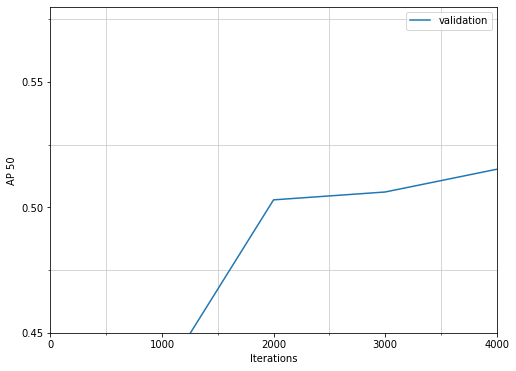

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.45, 0.58)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("AP 50")

mdf3 = mdf[~mdf["bbox/AP50"].isna()]
plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/AP50.png")

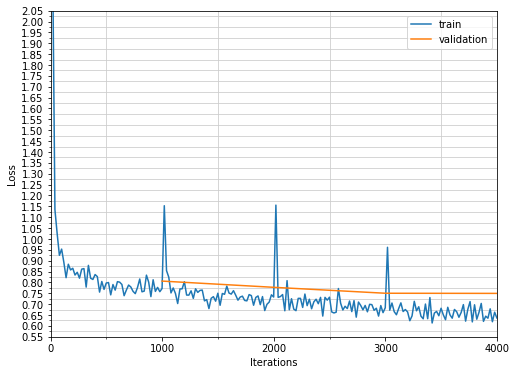

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.55, 2.05)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")

# plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')

mdf1 = mdf[~mdf["total_loss"].isna()]
plt.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    plt.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/loss.png")